<h1 style="text-align: center;">Estimating house prices in Clermont-Ferrand</h1>

<em><strong>Note:</strong><br>
This notebook is part of a project about the French counties and house prices. Please read the <a href=" https://github.com/Ashish-3/House-prices-in-France/blob/master/Readme.md">readme</a> file for more information:</em>



In this notebook we will build and test different models that will allow us to predict house prices in Clermont-Ferrand.

## Importing libraries

In [1]:
import numpy as np 
import pandas as pd

#show all the columns of a data
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium import plugins

import time
import math

## Importing data and quick filtering

First we import the transaction records.

In [2]:
df=pd.read_csv(r'val_immo.csv', 
               usecols=['Valeur fonciere', 'Voie', 'Code postal', 'Commune','Nombre pieces principales',
                        'Surface terrain','Surface Carrez']   
              )

print(df.shape)
df.head()

(1775051, 7)


,Valeur fonciere,Voie,Code postal,Commune,Nombre pieces principales,Surface terrain,Surface Carrez
0,209000.0,DES CHAMPAGNES,1160.0,PRIAY,4.0,940.0,90.0
1,134900.0,LE BIOLAY,1370.0,SAINT-ETIENNE-DU-BOIS,5.0,490.0,101.0
2,192000.0,DES LIBELLULES,1340.0,ATTIGNAT,4.0,708.0,88.0
3,45000.0,DU VIADUC,1250.0,CIZE,2.0,631.0,39.0
4,235000.0,JOACHIN DU BELLAY,1000.0,BOURG-EN-BRESSE,9.0,388.0,196.0


We filter the transaction and concentrate our study to houses in Clermond-Ferrand with :
    - Living area ('Surface Carrez') less than 200 m2
    - Land area ('Surface terrain') less than 1000 m2

In [3]:
# Let's filter our dataframe with CLERMONT-FERRAND  
df=df[df['Commune']=='CLERMONT FERRAND']
print(df.shape)

# Let's concentrate our study to houses with :
    # 'Surface Carrez' less than 200 m2
    # 'Surface terrain' less than 1000 m2
df=df[df['Surface terrain']<=1000]
df=df[df['Surface Carrez']<=200]

# Removing transactions with no price
df=df[~df['Valeur fonciere'].isna()]

print(df.shape)

(1382, 7)
(1381, 7)


Our observations and features will be in a DataFrame caled 'data'.

In [4]:
data=df[['Valeur fonciere', 'Nombre pieces principales', 'Surface Carrez', 'Surface terrain']]

## Quick exploratory analysis

Let's see how our observation are distributed with box plots. The style of the box plot used here is called "Letter value plots".

Text(0, 0.5, 'Transaction \n frequency')

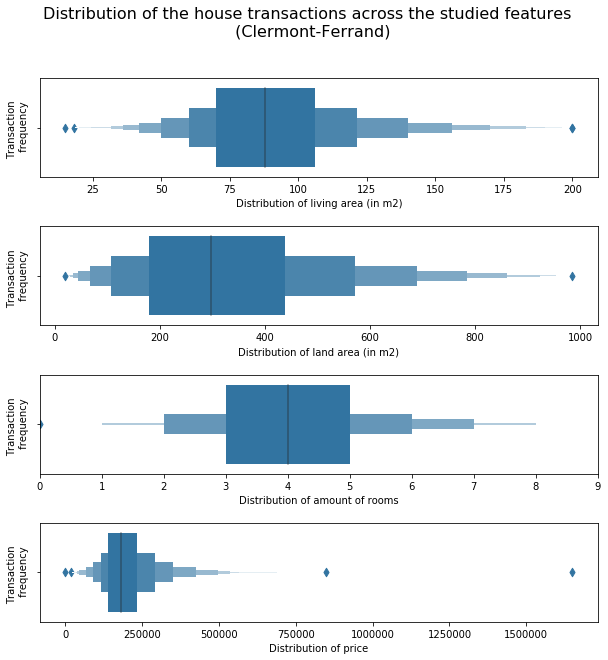

In [11]:
# Define subplots object
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,10) , gridspec_kw={'hspace': 0.5})

fig.suptitle('Distribution of the house transactions across the studied features \n (Clermont-Ferrand)', fontsize=16)

# Plot density
sns.boxenplot(df['Surface Carrez'],ax=ax1)
ax1.set_xlabel('Distribution of living area (in m2)')
ax1.set_ylabel('Transaction \n frequency')

# Plot revenue_median
sns.boxenplot(data['Surface terrain'],ax=ax2)
ax2.set_xlabel('Distribution of land area (in m2)')
ax2.set_ylabel('Transaction \n frequency')

# Plot age_median
sns.boxenplot(data['Nombre pieces principales'],ax=ax3)
ax3.set_xlabel('Distribution of amount of rooms')
ax3.set_ylabel('Transaction \n frequency')
ax3.set_xlim(0,9)

# Plot age_median
sns.boxenplot(data['Valeur fonciere'],ax=ax4)
ax4.set_xlabel('Distribution of price')
ax4.set_ylabel('Transaction \n frequency')


Let's have a quick overview of data and see how they are corelated.

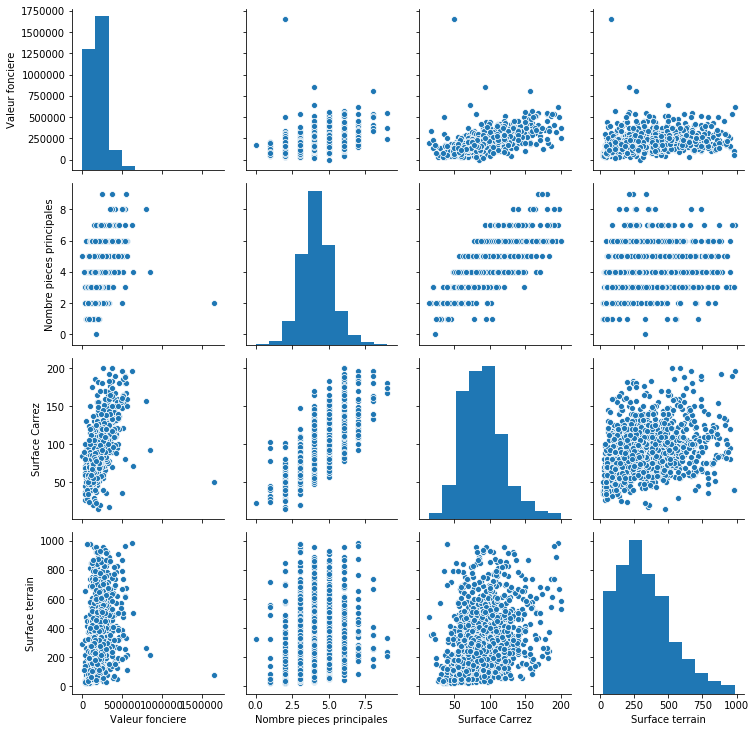

In [6]:
sns.pairplot(data=data)

# Modeling

Let's define the values used for modeling :

In [7]:
Y=data['Valeur fonciere'] # Defining target
X=data[['Nombre pieces principales','Surface Carrez', 'Surface terrain']] # Defining independant variable

Let's split the data in trainning and testing sets:

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

Let's define a function to later be able to plot easily the actual price values and our predictions.

In [9]:
def plotmodel(y_test,yhat) :
    width=7
    height=5
    plt.figure(figsize=(width, height))


    ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
    sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


    plt.title('Actual vs Fitted Values for house prices')
    plt.xlabel('Price')
    plt.ylabel('Proportion of houses')

    plt.show()
    plt.close()


Let's import scoring libraries :

In [10]:
from sklearn.metrics import mean_squared_error

In [11]:
from sklearn.metrics import r2_score

### Simple linear regression

In [12]:
from sklearn.linear_model import LinearRegression

Defining the linear regression model object and training it with the train set.

In [13]:
lm = LinearRegression()
lm.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Predicting prices with the test set and scoring the model

In [14]:
yhat=lm.predict(x_test)
lm_MSE=mean_squared_error(y_true=y_test, y_pred=yhat)
lm_r2=r2_score(y_true=y_test, y_pred=yhat)
print('MSE',lm_MSE, '\n', 'R2', lm_r2)

MSE 4946518740.520152 
 R2 0.4339899174206836


Let's plot the actual and modeled distribution plot of houses prices: 

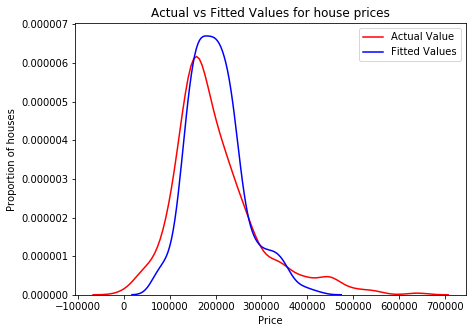

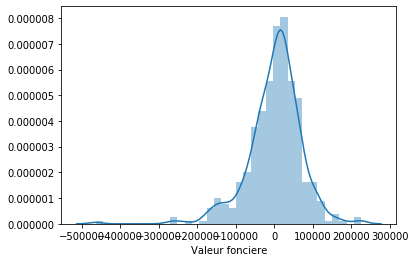

In [15]:
# Distribution plot of predicted prices and actual prices
plotmodel(y_test, yhat)

# Residual plot
sns.distplot(yhat-y_test)

###  Polynomial regression with data standardisation

Data Pipelines simplify the steps of processing the data. We use the module Pipeline to create a pipeline. We also use StandardScaler as a step in our pipeline.

In [16]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Defining a pipeline to standardise the data, define a polynomial model. Then train the model.

In [17]:
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=1 ,include_bias=False)), ('model',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=1, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

Predicting prices with the test set and scoring the model

In [18]:
yhat=pipe.predict(x_test)
poly_MSE=mean_squared_error(y_true=y_test, y_pred=yhat)
poly_r2=r2_score(y_true=y_test, y_pred=yhat)
print('MSE',poly_MSE, '\n', 'R2', poly_r2)

MSE 4946518740.520154 
 R2 0.4339899174206834


Let's plot the actual and modeled distribution plot of houses prices: 

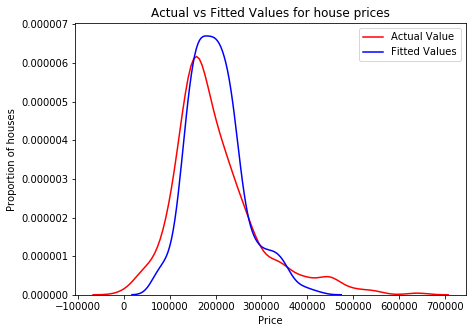

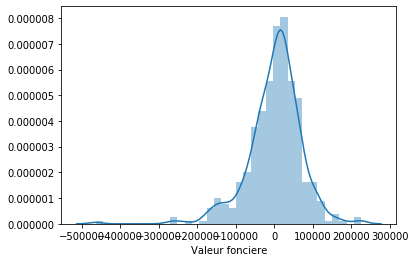

In [19]:
# Distribution plot of predicted prices and actual prices
plotmodel(y_test, yhat)

# Residual plot
sns.distplot(yhat-y_test)

Let's optimise the model. We have buil an algorithm that :
    - define the pipeline with several polynomial degrees
    - train the resulting model
    - test and score the model
    - return the best degree

In [20]:
# Choosing the best degre of the polynomial model with a loop
degrees=range(1,7)
listpoly_MSE=[]
listpoly_R2=[]
for degree in degrees :
    Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=degree ,include_bias=False)), ('model',LinearRegression())]
    pipe=Pipeline(Input)
    pipe.fit(x_train,y_train)
    yhat=pipe.predict(x_test)
    listpoly_MSE.append(mean_squared_error(y_true=y_test, y_pred=yhat))
    listpoly_R2.append(r2_score(y_true=y_test, y_pred=yhat))

# Printing the results
print('Max R2' , max(listpoly_R2),
    ' reached with an order of' , degrees[listpoly_R2.index(max(listpoly_R2))],
    '\n',
    'Min MSE' ,min(listpoly_MSE),
    ' reached with an order of', degrees[listpoly_MSE.index(min(listpoly_MSE))]
    )

Max R2 0.4377871011149863  reached with an order of 2 
 Min MSE 4913334101.441866  reached with an order of 2


Let's plot the score of each model according to their degrees. 

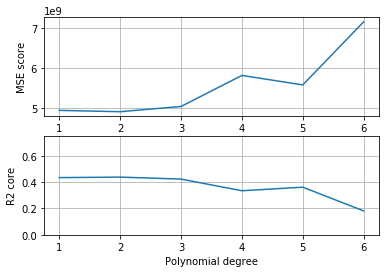

In [21]:
# Plot the scores according to the polynomial order of the models
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(degrees, listpoly_MSE)
ax2.plot(degrees, listpoly_R2)

ax1.set_xlabel('Polynomial degree')
ax1.set_ylabel('MSE score')

ax2.set_xlabel('Polynomial degree')
ax2.set_ylabel('R2 core')
ax2.set_ylim(0,0.75)

ax1.grid(True)
ax2.grid(True)

plt.show()

We can see that the polynomial degree perfom better with a degree of 1, which is a linear model.

### Ridge regression while using GridsearchCV

In [22]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

Let's try to build a ridge regression model. To do so, we will use the GridSearch funtion of SciKit learn, it actualy try several hyper-parameters to build an optimised model. Here we will try to create a ridge regression model by tuning the hyper-parameters such as alpha (regularization coefficient) and  try to see if normalising the data is useful. The models will be trained and tested by cross-validation, here we used a 5 fold cross-validation.   

In [23]:
parameters= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000],'normalize':[True,False]} ]
RR=Ridge()
Grid = GridSearchCV(RR, parameters,cv=5)
Grid.fit(X,Y)
BestRR=Grid.best_estimator_
BestRR

Ridge(alpha=10000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Predicting prices with the test set and scoring the model

In [24]:
yhat=BestRR.predict(x_test)
RR_MSE=mean_squared_error(y_true=y_test, y_pred=yhat)
RR_r2=r2_score(y_true=y_test, y_pred=yhat)
print('MSE',RR_MSE, '\n', 'R2', RR_r2)

MSE 4905392794.487339 
 R2 0.438695792669776


Let's plot the actual and modeled distribution plot of houses prices: 

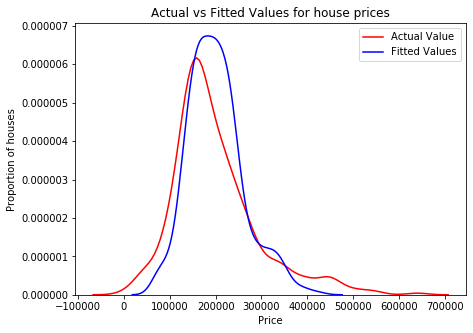

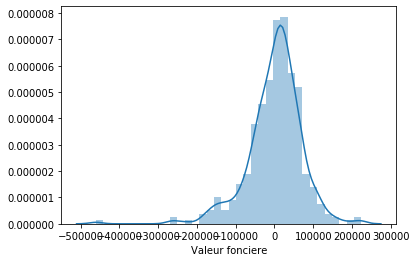

In [25]:
# Distribution plot of predicted prices and actual prices
plotmodel(y_test, yhat)

# Residual plot
sns.distplot(yhat-y_test)

###  Model chosen

Defining and diplaying a report of all the optimised models:

In [26]:
score_report={"Linear regression":[lm_r2,lm_MSE],
             "Polynomial regression":[poly_r2,poly_MSE],
             "Ridge regression":[RR_r2,RR_MSE]}
score_report=pd.DataFrame.from_dict(score_report, orient='index', columns=['R2 score','MSE score'])
score_report

,R2 score,MSE score
Linear regression,0.433990,4.946519e+09
Polynomial regression,0.433990,4.946519e+09
Ridge regression,0.438696,4.905393e+09


We can conclude that the difference in performance of different models is not very significant. We can also note that the best Polynomial regression is in fact a linear regression model. Hence, for the sake of simplicity a linear regression model was chosen to estimate house prices. It performs as well as (if not better than) the other models in this case study.

### Using the model for estimations

Now that we have chosen the model to be used (linear regression) let's build a small tool to predict the price of houses.

Importing the Ipywidget library to do built the tool.

In [27]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Creating the model and creating a function to predict houses :

In [28]:
# Defining and trainning model to be used
lm = LinearRegression()
lm.fit(X,Y)

# Defining a function to estimate the price
def estimate(Nb_pieces,Surface_Carrez, Surface_terrain) :
    x={'Nombre pieces principales':[Nb_pieces],
          'Surface Carrez':[Surface_Carrez], 
          'Surface terrain' :[Surface_terrain]}
    x=pd.DataFrame.from_dict(x, orient='columns')
    return print('Estimated price :',lm.predict(x)[0])

Now after initializing the widgets, we now have a tool where we can predict the price of houses in Clermont-Ferrand. 

In [29]:
# Let"s define widgets to use the estimator function

Nb_pieces=widgets.FloatSlider(value=4,min=3, max=5, step=1, description='NB pieces')
Surface_Carrez=widgets.FloatSlider(value=100,min=50, max=150, step=10, description='S Carrez')
Surface_terrain=widgets.FloatSlider(value=200,min=60, max=600, step=25, description='S terrain')

interact(estimate, Nb_pieces=Nb_pieces,Surface_Carrez=Surface_Carrez, Surface_terrain=Surface_terrain)


interactive(children=(FloatSlider(value=4.0, description='NB pieces', max=5.0, min=3.0, step=1.0), FloatSlider…

<function __main__.estimate(Nb_pieces, Surface_Carrez, Surface_terrain)>